### Figures for my University of Waterloo colloquium in 2019 Feb.

In [190]:
import os, pdb
import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy.stats import binned_statistic
import warnings
from matplotlib.ticker import FormatStrFormatter, MultipleLocator, ScalarFormatter
import matplotlib.pyplot as plt

In [2]:
from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astrometry.libkd.spherematch import match_radec

In [3]:
import colossus.halo
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [306]:
import legacyhalos.io
import legacyhalos.misc
from legacyhalos.misc import lambda2mhalo, plot_style
sns, colors = plot_style(talk=True)
linestyle = ['-', '--', '-.', ':']

In [5]:
%matplotlib inline

In [186]:
hdefault = 0.7 # 0.677 # Hubble constant
omega_b = 0.048 # from Knebe+18
omega_m = 0.307

In [6]:
datadir = legacyhalos.io.paper2_dir(data=True)
talkdir = os.path.join(legacyhalos.io.legacyhalos_dir(), 'science', 'talks', 'waterloo-2019feb')
print(talkdir)

/Users/ioannis/research/projects/legacyhalos/science/talks/waterloo-2019feb


In [193]:
def mstar_label():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-2}\, \mathcal{M}_{\odot})$'
def mhalo_label():
    return r'$\log_{10}\, (\mathcal{M}_{\rm halo}\, /\, \mathcal{M}_{\odot})$'
def mstar_label2():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-1}\, \mathcal{M}_{\odot})$'
def mstar_label3():
    return r'$\log_{10}\, (\mathcal{M}_{*}\, /\, \mathcal{M}_{\odot})$'
def phi_label():
    return r'$\log_{10}\, (\Phi\ /\ h^{3}$ Mpc$^{-3}$ dex$^{-1})$'
def phi_label2():
    return r'$\log_{10}\, (\Phi\ /\ {\rm Mpc}^{-3}\ {\rm dex}^{-1})$'
def mstar_mhalo_label():
    return r'$log_{10}\, (\mathcal{M}_{*}\ /\ \mathcal{M}_{\rm halo})\ /\ (\Omega_b\ /\ \Omega_m)$'

## Remake some plots from the literature.

In [180]:
def wang_fig1(png=None):
    """Extracted from WebPlotDigitizer."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fq_sat_mstar = np.array([
        [9.205231645430983, 0.4237742324121062],
        [9.609232959731301, 0.44946150195319645],
        [10.008196122814065, 0.5406155306487535],
        [10.407597386002703, 0.6608594063743567],
        [10.806779599138405, 0.7665583585849369],
        [11.20658245409076, 0.913467927421416]])
    fq_cen_mstar = np.array([
        [9.200449052608523, 0.1062100690007668],
        [9.598755065532476, 0.1537293271512541],
        [10.010642181738529, 0.30303384323317895],
        [10.405151327078238, 0.4984410937899313],
        [10.799733489102262, 0.6986966521850244],
        [11.212022197072033, 0.874666861377825]])
    
    fq_cen_mhalo = np.array([
        [11.485761355613086, 0.19699929395151805],
        [12.21528594963521, 0.5687926570957873],
        [12.712697105201224, 0.7221228524358672],
        [13.212579430454223, 0.8245469522240526],
        [13.70322428806778, 0.9172628853847963],
        [14.215403624382207, 0.9663685573076016],
        [14.711108496116733, 0.9548481995763707]])
    fq_sat_mhalo = np.array([
        [11.495704871734526, 0.1921628618498471],
        [12.227994822311132, 0.3069898799717581],
        [12.725876676865145, 0.45062367615909626],
        [13.217698281948694, 0.5190986114379853],
        [13.728818545540127, 0.5900211814544597],
        [14.220287126382676, 0.6657684160979053],
        [14.720640150623677, 0.7584961167333488]])
    
    ax1.scatter(fq_cen_mstar[:, 0], fq_cen_mstar[:, 1], label='Centrals',
                s=100, color='firebrick', edgecolor='black', marker='s')
    ax1.scatter(fq_sat_mstar[:, 0], fq_sat_mstar[:, 1], label='Satellites',
                s=100, color='blue')
    ax1.legend(loc='upper left', frameon=True)
    
    ax1.set_ylim(0, 1)
    ax1.set_xlim(9, 11.5)
    ax1.set_ylabel('Quenched Fraction')
    ax1.set_xlabel(r'$\log_{{10}}\,(\mathcal{M_{*}}\,/\,\mathcal{M_{\odot}})$')
    
    ax2.scatter(fq_cen_mhalo[:, 0], fq_cen_mhalo[:, 1], label='Centrals',
                s=100, color='firebrick', edgecolor='black', marker='s')
    ax2.scatter(fq_sat_mhalo[:, 0], fq_sat_mhalo[:, 1], label='Satellites',
                s=100, color='blue')
    
    ax2.set_ylim(0, 1)
    ax2.set_xlim(11, 15)
    ax2.set_xlabel(r'$\log_{{10}}\,(\mathcal{M_{\rm halo}}\,/\,\mathcal{M_{\odot}})$')

    plt.subplots_adjust(left=0.1, wspace=0.1, right=0.98, bottom=0.18, top=0.95)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

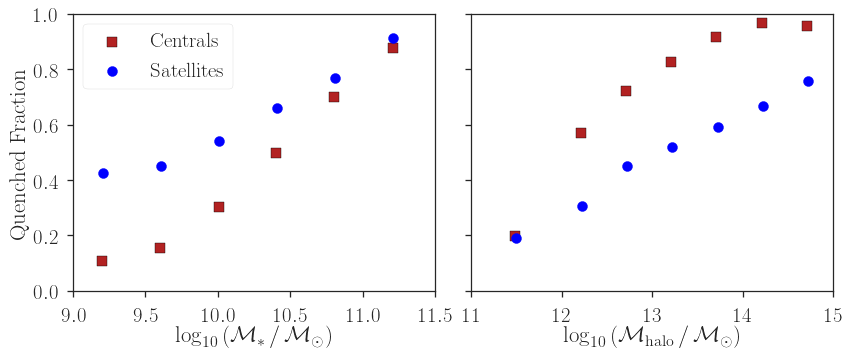

In [181]:
wang_fig1(png='wang18-fig1.png')

## Stellar mass functions

In [187]:
def read_carnage_smf(fullrange=False, seed=None, h=hdefault):
    """Data taken from Knebe+18."""
    
    carnagedir = os.path.join(os.getenv('CATALOGS_DIR'), 'carnage')
    
    labels = ('DLB07', 'GalICS2.0', 'LGALAXIES', 'SAG', 'MICE', 
              'SAGE', 'Galform-GP14', 'MORGANA', 'ySAM')    
    data = []
    for model in ('DLB07-c01.txt', 'GalICS2.0-c01.txt', 'LGALAXIES-c01.txt',
                  'SAG-c01.txt', 'MICE-c01.txt', 'SAGE-c01.txt', 
                  'Galform-GP14-c01.txt', 'MORGANA-c01.txt', 'ySAM-c01.txt'):
        dd = ascii.read(os.path.join(carnagedir, 'Fig.1', model), 
                        format='basic', names=('mstar', 'phi', 'junk1', 'junk2', 'junk3'),
                        exclude_names=('junk1', 'junk2', 'junk3'))
        good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
        dd = dd[good]
        
        dd['mstar'] = np.log10(dd['mstar'] / h)
        dd['phi'] = np.log10(dd['phi'] * h**3)
        data.append(dd)
        
    if fullrange:
        rand = np.random.RandomState(seed)
        
        mstar, phi = [], []
        for dd in data:
            #good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
            mstar.append(dd['mstar']+ rand.normal(loc=0, scale=0.05))
            phi.append(dd['phi'])
        mstar = np.hstack(mstar)
        phi = np.hstack(phi)
        
        width = 0.2
        mstarrange = (9.1, 12.5)
        nbins = np.int(np.ptp(mstarrange) / width)
        
        phimin, mstar_edges, _ = binned_statistic(mstar, phi, statistic='min', bins=nbins, 
                                                  range=mstarrange)
        phimax, _, _ = binned_statistic(mstar, phi, statistic='max', bins=nbins,
                                                  range=mstarrange)
        mstar = mstar_edges[1:] - width / 2
        
        return mstar, phimin, phimax
    else:
        return data, labels

In [202]:
def qa_carnage_smf(individual=True, fullrange=False, png=None, ylim=None):
    fig, ax = plt.subplots(figsize=(10, 7))
    if individual:
        data, labels = read_carnage_smf()
        ls = ('-', '--', '-.', ':')
        for dd, ll in zip(data, labels):
            ax.plot(dd['mstar'], dd['phi'], label=ll, lw=4,
                    ls=ls[0], alpha=0.8)
            ls = np.roll(ls, 1)

    if fullrange:
        mstar, phimin, phimax = read_carnage_smf(fullrange=True, seed=1)
        ax.fill_between(mstar, phimin, phimax, alpha=0.2, color='gray',
                       label='All CARNage Models')

    ax.grid()
    ax.set_xlim(9, 12.5)
    if ylim:
        ax.set_ylim(ylim)

    ax.set_xlabel(mstar_label3())
    ax.set_ylabel(phi_label2())
    ax.legend(loc='lower left', ncol=2, fontsize=16)
    
    plt.subplots_adjust(top=0.95)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

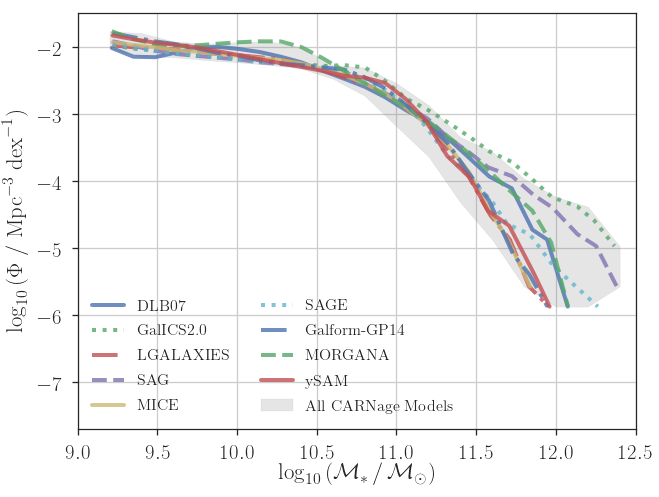

In [203]:
qa_carnage_smf(fullrange=True, ylim=(-7.7, -1.5), png='smf-carnage-fullrange.png')

In [204]:
def read_li09():
    """Read data from Li & White 2009."""

    lidir = os.path.join(os.getenv('CATALOGS_DIR'), '09li')
    smffile = os.path.join(lidir, 'massfun.dr72bbright0')

    data = ascii.read(smffile, format='basic', names=('masslo', 'masshi', 'meanmass', 'phi', 'phierr'))
    
    mstar = data['meanmass'] - 2*np.log10(0.7)
    phi = np.log10(data['phi'].data * 0.7**3)
    phierr = data['phierr'] / data['phi'] / np.log(10)
    
    return mstar, phi, phi-phierr, phi+phierr

In [205]:
def read_moustakas13(starforming=False, quiescent=False):
    """Read data from Moustakas+13."""

    moosedir = os.path.join(os.getenv('CATALOGS_DIR'), '13moustakas')
    
    suffix = 'all'
    if starforming:
        suffix = 'starforming'
    if quiescent:
        suffix = 'quiescent'
    smffile = os.path.join(moosedir, 'smf_{}_supergrid01.txt'.format(suffix))

    data = ascii.read(smffile, format='basic', names=('zlo', 'zhi', 'ngal', 'mstar', 
                                                      'limit', 'phi', 'philo', 'phihi', 
                                                      'phicv'))
    loz = np.where( data['zhi'] <= 0.2 )[0]
    data = data[loz]
    
    return data['mstar'], data['phi'], data['phi'] - data['phicv'], data['phi'] + data['phicv']

def read_bernardi17(h=hdefault, dustfree=True):
    """Read data from Bernardi+17."""
    moosedir = os.path.join(os.getenv('CATALOGS_DIR'), '17bernardi')
    data = pd.read_table(os.path.join(moosedir, 'smf.txt'), 
                         delim_whitespace=True)

    mstar = data['mstar'].values # - np.log10(h**2)
    if dustfree:
        phi = data['phi_M14_dustfree_obs'].values # + np.log10(h**3)
        philo = phi - data['phierr_M14_dustfree'].values
        phihi = phi + data['phierr_M14_dustfree'].values
    else:
        phi = data['phi_M14_dust_obs'].values # + np.log10(h**3)
        philo = phi - data['phierr_M14_dust'].values
        phihi = phi + data['phierr_M14_dust'].values
    
    return mstar, phi, philo, phihi

In [208]:
def read_huang18(cModel=False, BCG=False, total=False, h=hdefault):
    
    huangdir = os.path.join(os.getenv('CATALOGS_DIR'), '18huang')

    if BCG:
        censuffix = 'cenhighmh'
    else:
        censuffix = 'cenlowmh'
        
    if cModel:
        fluxsuffix = 'cmodel'
    else:
        fluxsuffix = '100kpc'

    if total:
        data = Table.read(os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format('cenhighmh', fluxsuffix)))
        _data = Table.read(os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format('cenlowmh', fluxsuffix)))
        #print(data['logm_mean'], data['smf'].data, _data['smf'].data)
        
        data['smf'] += _data['smf']
        data['smf_err'] = np.sqrt( data['smf_err']**2 + _data['smf_err']**2 )
        data['smf_low'] = np.sqrt( data['smf_low']**2 + _data['smf_low']**2 )
        data['smf_upp'] = np.sqrt( data['smf_upp']**2 + _data['smf_upp']**2 )
    else:
        smffile = os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format(censuffix, fluxsuffix))
        data = Table.read(smffile)
    
    good = np.where( (data['logm_0'] >= 11.4) * (data['smf_err'] > 0) )[0]
    mstar = data['logm_mean'][good] # - 2*np.log10(h)
    phi = np.log10(data['smf'][good]) # * h**3)
    phierr = data['smf_err'][good] / data['smf'][good] / np.log(10)
    philo = phi - data['smf_low'][good] / data['smf'][good] / np.log(10)
    phihi = phi + data['smf_upp'][good] / data['smf'][good] / np.log(10)
    
    return mstar, phi, philo, phihi

In [209]:
def double_schechter(logmass, logmstar1=10.0, logmstar2=11.0, 
                     alpha1=-1, alpha2=-1.1, phistar1=0.008, 
                     phistar2=0.001):
    
    mratio1 = pow(10, logmass - logmstar1)
    mratio2 = pow(10, logmass - logmstar2)
    model = np.log(10) * ( np.exp(-mratio1) * phistar1 * mratio1**(alpha1 + 1) + 
                           np.exp(-mratio2) * phistar2 * mratio2**(alpha2+1) )
    
    return model

def read_dsouza15(h=hdefault):
    logmass = np.arange(9.5, 12.5, 0.05)
    
    phimodel = double_schechter(logmass, logmstar1=10.615, logmstar2=10.995,
                                alpha1=-1.082, alpha2=-1.120, 
                                phistar1=0.008579, phistar2=0.000355)
    
    logmass = logmass - np.log10(h**2)
    logphi = np.log10(phimodel * h**3)
    good = np.where(logphi > -7.6)[0]
    
    return logmass[good], logphi[good]

In [213]:
def qa_smf(plot_carnage=True, plot_huang=True, png=None):
    fig, ax = plt.subplots(figsize=(10, 7))

    # Model shaded region
    if plot_carnage:
        mstar, phimin, phimax = read_carnage_smf(fullrange=True, seed=1)
        ax.fill_between(mstar, phimin, phimax, alpha=0.2, color='gray', 
                        label='CARNage Models ($z\sim0$)')

    # Li & White 09
    mstar, phi, philo, phihi = read_li09()
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Li \& White 09 ($z\sim0.1$)')

    # Moustakas+13
    mstar, phi, philo, phihi = read_moustakas13()
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Moustakas+13 ($z\sim0.1$)')
    
    # D'Souza+15
    mstar, phi = read_dsouza15()
    ax.fill_between(mstar, phi, phi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label="D'Souza+15 ($z\sim0.1$)")
    
    # Bernardi+17
    mstar, phi, philo, phihi = read_bernardi17(dustfree=True)
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Bernardi+17 ($z\sim0.1$)')

    # Huang+18
    if plot_huang:
        mstar, phi, philo, phihi = read_huang18(cModel=False, BCG=False, total=True)
        ax.fill_between(mstar, philo, phihi, alpha=0.3)
        ax.plot(mstar, phi, lw=3, ls='-', label='Huang+18 (z~0.4)')# (HSC, <100 kpc)')

    ax.set_xlabel(mstar_label3())
    ax.set_ylabel(phi_label2())
    
    ax.set_ylim(-7.7, -1.5)
    ax.set_xlim(9, 12.5)
    
    ax.grid()
    hh, ll = ax.get_legend_handles_labels()
    #handles = handles[np.array(list(1, 2, 0
    #labels = labels[np.array([1, 2, 0])]
    ax.legend(loc='lower left', fontsize=18)
    #ax.legend([hh[0],hh[1],hh[2],hh[3]], [ll[0],ll[1],ll[2]], loc='lower left', fontsize=18)
    
    plt.subplots_adjust(top=0.95)    
    
    if png:
        plt.savefig(png)

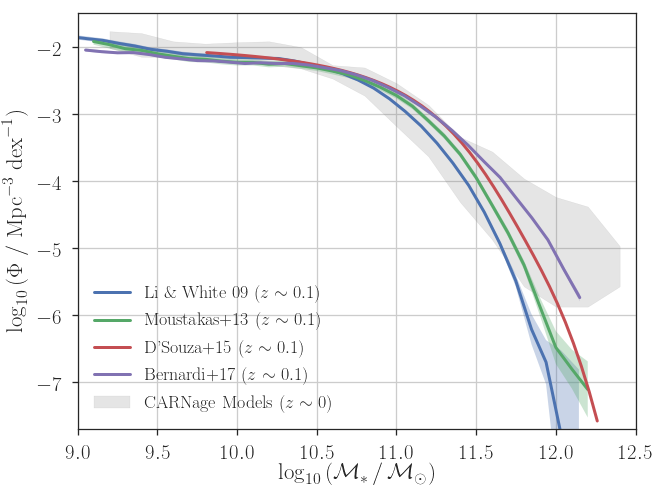

In [214]:
qa_smf(plot_carnage=True, plot_huang=False, png=os.path.join(talkdir, 'smf-data-nohuang.png'))

### Read the catalogs we need.

In [7]:
sample = legacyhalos.io.read_paper2_sample()
#lsphot = legacyhalos.io.read_paper2_sample(isedfit_lsphot=True, verbose=True)
#sdssphot = legacyhalos.io.read_paper2_sample(isedfit_sdssphot=True, verbose=True)

#### Montage of 100 random clusters.

In [218]:
M200c = lambda2mhalo(sample['LAMBDA_CHISQ'].data, redshift=sample['Z_LAMBDA'].data)

In [241]:
def make_montage(infiles):
    montagefile = os.path.join(talkdir, 'centrals-gallery.png')

    ncol = 8
    nrow = 6
    
    cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 512x512 '.format(ncol, nrow)
    cmd = cmd+' '.join([inff for inff in infiles])
    cmd = cmd+' {}'.format(montagefile)
    #print(cmd)
    os.system(cmd)        
    print('Writing {}'.format(montagefile))

In [260]:
galaxy, galaxydir = legacyhalos.io.get_galaxy_galaxydir(sample)
rand = np.random.RandomState(seed=9)
these = rand.choice(len(galaxy), 48, replace=False)
srt = np.argsort(M200c[these])
indx = these[srt]
indx[6] = indx[6]+1
indx[27] = indx[27]+1
indx[28] = indx[28]+1
print(M200c[indx])
infiles = [os.path.join(galdir, '{}-custom-image-grz.jpg'.format(gal)) for gal, galdir in zip(galaxy[indx], galaxydir[indx])]
#M200c[these[srt]]

[ 13.43359661  13.43931961  13.46373844  13.48460484  13.51391125
  13.52491474  13.46820831  13.53076172  13.59176445  13.59494114
  13.65868187  13.66848755  13.74181557  13.76286507  13.78921986
  13.81514931  14.0018034   14.02677059  14.02912903  14.06542778
  14.06944847  14.07889462  14.08047104  14.1131773   14.13405228
  14.13824749  14.1668787   14.4099617   14.28771114  14.26496124
  14.28142262  14.31115723  14.38617039  14.43645191  14.45478535
  14.45869827  14.46829224  14.49530029  14.58505917  14.61601639
  14.63002777  14.70298958  14.79010105  14.79089642  14.82102013
  14.86587143  14.93194199  14.98651314]


In [262]:
if False:
    make_montage(infiles)

In [263]:
profiles1dmstar = Table.read(os.path.join(datadir, 'paper2-profiles1d-mstar.fits'))
profiles1dmstar.colnames

['MEM_MATCH_ID',
 'RA',
 'DEC',
 'Z',
 'LAMBDA_CHISQ',
 'ID_CENT',
 'RMAX_G',
 'RMAX_R',
 'RMAX_Z',
 'RAD',
 'RAD_AREA',
 'MSTAR10',
 'MSTAR10_ERR',
 'MSTAR30',
 'MSTAR30_ERR',
 'MSTAR100',
 'MSTAR100_ERR',
 'MSTARRMAX',
 'MSTARRMAX_ERR',
 'MSTARRAD',
 'MSTARRAD_ERR',
 'MURAD',
 'MURAD_ERR']

## Stellar mass density profiles in different bins of stellar mass / halo mass.

In [264]:
M200c = lambda2mhalo(sample['LAMBDA_CHISQ'], redshift=sample['Z_LAMBDA'])

In [265]:
dmhalo = 0.5
mhalomin = np.arange(13.5, 15, dmhalo)
mhalomax = mhalomin + dmhalo

In [329]:
#dmstar = 0.5
#mstarmin = np.arange(11.0, 13, dmstar)
#mstarmax = mstarmin + dmstar
#mstarmin = [11, 11.5, 11.75, 12]
#mstarmax = [11.5, 11.75, 12, 12.5]
mstarmin = [11.0, 11.4, 11.8]
mstarmax = [11.4, 11.8, 12.2]
print(mstarmin, mstarmax)

[11.0, 11.4, 11.8] [11.4, 11.8, 12.2]


In [330]:
def mean_mstarprofile(mhalo, mhalomin=14, mhalomax=15, R200norm=True):
    """Mean cumulative stellar mass profiles."""
    ww = np.where((mhalo > mhalomin) * (mhalo < mhalomax))[0]
    
    if R200norm:
        medmhalo, medz = np.median(mhalo[ww]), 0.3 # np.median(profiles1dmstar['Z'][ww])
        rnorm = colossus.halo.mass_so.M_to_R(10**medmhalo, medz, '200c') # use Z_LAMBDA here!
    else:
        rnorm = 1.0

    radfrac, mstarfrac = [], []
    for pp in profiles1dmstar[ww]:
        if pp['MSTAR100'] > 0:
            good = pp['MSTARRAD'] > 0
            mstarsum = np.log10(np.cumsum(10**pp['MSTARRAD'][good]))
            #if R200norm:
            #    rnorm = colossus.halo.mass_so.M_to_R(10**mhalo[ww[ii]], pp['Z'], '200c') # use Z_LAMBDA here!
            #else:
            #    rnorm = 1.0
            radfrac.append(np.log10(pp['RAD'][good] / rnorm)) # normalize by R200!
            mstarfrac.append(mstarsum)
            #mstarfrac.append(10**(mstarsum-mstarsum[-1]))

    stats = legacyhalos.misc.statsinbins(np.hstack(radfrac), np.hstack(mstarfrac), binsize=0.1)
    return stats, radfrac, mstarfrac

In [331]:
def mean_muprofile_mhalo(mhalo, mhalomin=14, mhalomax=15):
    """Mean stellar mass density profiles in bins of halo mass."""
    ww = np.where((mhalo > mhalomin) * (mhalo < mhalomax))[0]
    
    radfrac, mstarfrac = [], []
    for pp in profiles1dmstar[ww]:
        if pp['MSTAR100'] > 0:
            good = pp['MURAD'] > 0
            mstarsum = pp['MURAD'][good]

            radfrac.append(pp['RAD'][good]**0.25)
            mstarfrac.append(mstarsum)

    stats = legacyhalos.misc.statsinbins(np.hstack(radfrac), np.hstack(mstarfrac), binsize=0.1)
    return stats, radfrac, mstarfrac

In [332]:
def mean_muprofile_mstar(mstar, mstarmin=10.5, mstarmax=12.5):
    """Mean stellar mass density profiles in bins of stellar mass."""
    ww = np.where((mstar > mstarmin) * (mstar < mstarmax))[0]
    radfrac, mstarfrac = [], []
    for pp in profiles1dmstar[ww]:
        if pp['MSTAR100'] > 0:
            good = pp['MURAD'] > 0
            mstarsum = pp['MURAD'][good]

            radfrac.append(pp['RAD'][good]**0.25)
            mstarfrac.append(mstarsum)

    stats = legacyhalos.misc.statsinbins(np.hstack(radfrac), np.hstack(mstarfrac), binsize=0.1)
    #import pdb ; pdb.set_trace()
    return stats, radfrac, mstarfrac

In [341]:
def qa_muprofile_mstar(png=None):

    good = profiles1dmstar['MSTAR100'] > 0
    goodmstar = profiles1dmstar['MSTAR100'][good]
    
    fig, ax = plt.subplots(figsize=(10, 7))
    for ii, (hmin, hmax) in enumerate(zip(mstarmin, mstarmax)):
        stats, radfrac, mstarfrac = mean_muprofile_mstar(goodmstar, hmin, hmax)
        ax.plot(stats['xbin'], stats['ymean'], lw=4, color=colors[ii], 
                ls=linestyle[ii], 
                label=r'${:.1f}<\log_{{10}}\,(\mathcal{{M}}_{{*,r<100\,kpc}}/\mathcal{{M}}_\odot)<{:.1f}$'.format(hmin, hmax))
        for rr, mm in zip(radfrac, mstarfrac):
            ax.plot(rr, mm, lw=1, alpha=0.05, color=colors[ii])
            
    ax.legend(loc='upper right', fontsize=18)
    ax.set_ylabel(r'$\log_{{10}}\,[\mu_{{*}}\ /\ (\mathcal{{M}}_{\odot}\ kpc^{-2}$)]')
    #ax.set_ylim(0, 1.02)
    ax.set_ylim(5, 10.5)
    ax.set_xlim(0.8, 3.3)
    
    ylim = ax.get_ylim()
    ax.fill_between([0, 0.9], [ylim[1], ylim[1]], [ylim[0], ylim[0]], 
                    color='grey', alpha=0.3)
    ax.text(0.025, 0.1, 'PSF', ha='center', va='center', rotation=90,
            transform=ax.transAxes, fontsize=14)

    ax.set_xlabel(r'$(r\ /\ kpc)^{1/4}$')
    
    ax2 = ax.twiny()
    xlim = ax.get_xlim()
    ax2.set_xlim((xlim[0]**4, xlim[1]**4))
    ax2.set_xlabel(r'$r\ /\ kpc$')
    ax2.set_xticks((10, 30, 50, 70, 100, 120, 140))
        
    if png:
        plt.savefig(os.path.join(talkdir, png))            

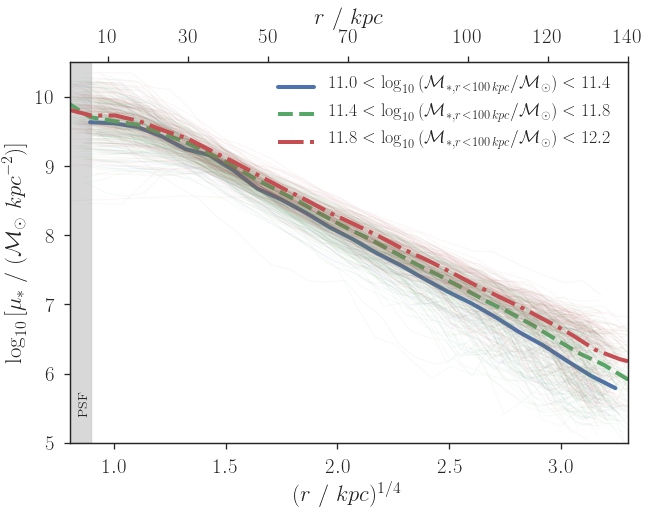

In [342]:
qa_muprofile_mstar(png='mustar-radius-mstar.png')

In [343]:
def qa_muprofile_mhalo(png=None):

    fig, ax = plt.subplots(figsize=(10, 7))
    for ii, (hmin, hmax) in enumerate(zip(mhalomin, mhalomax)):
        stats, radfrac, mstarfrac = mean_muprofile_mhalo(M200c, hmin, hmax)
        ax.plot(stats['xbin'], stats['ymean'], lw=4, color=colors[ii], 
                ls=linestyle[ii], 
                label=r'${:.1f}<\log_{{10}}\,(\mathcal{{M}}_{{200c}}/\mathcal{{M}}_\odot)<{:.1f}$'.format(hmin, hmax))
        for rr, mm in zip(radfrac, mstarfrac):
            ax.plot(rr, mm, lw=1, alpha=0.05, color=colors[ii])
            
    ax.legend(loc='upper right', fontsize=18)
    ax.set_ylabel(r'$\log_{{10}}\,[\mu_{{*}}\ /\ (\mathcal{{M}}_{\odot}\ kpc^{-2}$)]')
    #ax.set_ylim(0, 1.02)
    ax.set_ylim(5, 10.5)
    ax.set_xlim(0.8, 3.3)
    
    ylim = ax.get_ylim()
    ax.fill_between([0, 0.9], [ylim[1], ylim[1]], [ylim[0], ylim[0]], 
                    color='grey', alpha=0.3)
    ax.text(0.025, 0.1, 'PSF', ha='center', va='center', rotation=90,
            transform=ax.transAxes, fontsize=14)

    ax.set_xlabel(r'$(r\ /\ kpc)^{1/4}$')
    
    ax2 = ax.twiny()
    xlim = ax.get_xlim()
    ax2.set_xlim((xlim[0]**4, xlim[1]**4))
    ax2.set_xlabel(r'$r\ /\ kpc$')
    ax2.set_xticks((10, 30, 50, 70, 100, 120, 140))
        
    if png:
        plt.savefig(os.path.join(talkdir, png))            

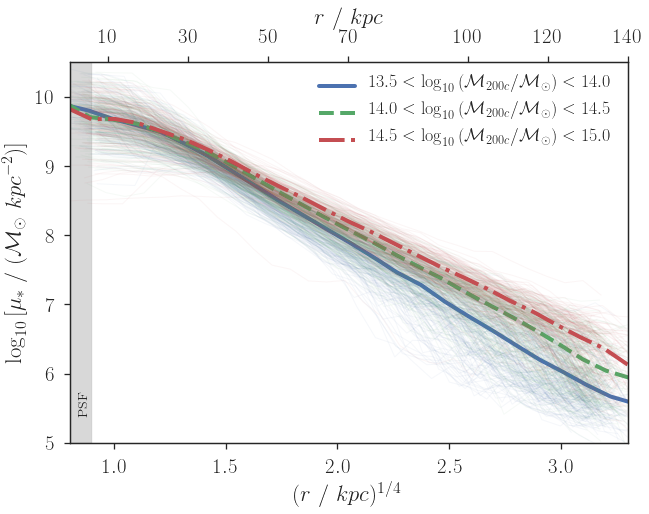

In [344]:
qa_muprofile_mhalo(png='mustar-radius-mhalo.png')

In [ ]:
def qa_mstarprofile():
    fig, ax = plt.subplots(figsize=(8, 6))
    for ii, (hmin, hmax) in enumerate(zip(mhalomin, mhalomax)):
        stats, radfrac, mstarfrac = mean_mstarprofile(M200c, hmin, hmax, R200norm=False)
        ax.plot(stats['xmean'], stats['ymean'], lw=4, color=colors[ii], 
                label=r'${:.1f}<\log\,(M_h/M_\odot)<{:.1f}$'.format(hmin, hmax))
        for rr, mm in zip(radfrac, mstarfrac):
            ax.plot(rr, mm, lw=1, alpha=0.03, color=colors[ii])
        
    ax.legend(loc='upper left', fontsize=14)
    ax.set_ylabel(r'$\log_{10}\,(M_{BCG}\ /\ M_{\odot})$')
    #ax.set_ylim(0, 1.02)
    ax.set_ylim(10, 12.2)

    if False:
        ax.set_xlim(-3.5, -0.05)
        ax.set_xlabel(r'$\log_{10}\,(R\ /\ R_{200c})$')
    else:
        ax.set_xlim(-0.5, 2.2)
        ax.set_xlabel(r'$\log_{10}\,(R\ /\ kpc)$')   

In [ ]:
stop

## Stellar mass-halo mass relation

In [270]:
def qa_smhm_obs(aperture='rmax', png=None):
    """Generate figures of the stellar mass vs halo mass and of
    the stellar mass / halo mass vs halo mass relations, including
    data from the literature.
    
    """
    from colossus.halo import mass_defs
    
    # The linear fit from Kravtsov is as a function of M500c; convert it to 
    # M200c here assuming a halo concentration of 3.5.
    #mm, _, _ = mass_defs.changeMassDefinition(10**14.5, 3.5, 0.0, '500c', '200c')
    #offset = np.log10(mm / 10**14.5)
    
    ap2mstar = {'10kpc': 'MSTAR10', '30kpc': 'MSTAR30', '100kpc': 'MSTAR100', 'rmax': 'MSTARRMAX'}
    mstarlabel = ap2mstar[aperture]
    good = np.where(profiles1dmstar[mstarlabel] > 0)[0]
    mstar, mstarerr = profiles1dmstar[mstarlabel][good], profiles1dmstar['{}_ERR'.format(mstarlabel)][good]
        
    lambda_chisq, z = sample['LAMBDA_CHISQ'][good], sample['Z_LAMBDA'][good]
    rich = lambda_chisq > 100
    
    M200c = lambda2mhalo(lambda_chisq, redshift=z)
    stats = legacyhalos.misc.statsinbins(M200c, mstar)
    
    col = iter(colors)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    gonz = legacyhalos.io.literature(gonzalez=True, kravtsov=False)
    krav = legacyhalos.io.literature(kravtsov=True, gonzalez=False)
    
    g = ax.errorbar(gonz['m200c'], gonz['mbcg'], yerr=gonz['mbcg_err'], color=next(col),
                    alpha=0.8, fmt='D', label='Gonzalez+13', markersize=10,
                    capsize=5, elinewidth=2, markeredgewidth=2)
    k = ax.errorbar(krav['m200c'], krav['mbcg'], yerr=krav['mbcg_err'], color=next(col),
                    alpha=0.8, fmt='s', label='Kravtsov+18', markersize=10,
                    capsize=5, elinewidth=2, markeredgewidth=2)
                    
    #r = ax.scatter(mhalo[rich], mstar[rich], alpha=0.9, color=next(col),
    #               edgecolor='k', marker='D', s=50, label='\emph{legacyhalos} ($\lambda>100$)')
    #r = ax.scatter(M200c, mstar, alpha=0.5, color='tan', #next(col),
    #               edgecolor='k', marker='D', s=20, label='Moustakas+19')
    r = ax.errorbar(M200c[rich], mstar[rich], mstarerr[rich], alpha=0.7, color=next(col),
                    fmt='o', markersize=12, label='Moustakas+19 ($\lambda>100$)',
                    capsize=5, elinewidth=2, markeredgewidth=2,
                    markeredgecolor='k')
    #r = ax.scatter(M200c[rich], mstar[rich], alpha=0.9, color=next(col),
    #               edgecolor='k', marker='D', s=30, label='Moustakas+19')
    #r = ax.errorbar(mhalo, mstar, yerr=mstarerr, alpha=0.9, color=next(col),
    #                marker='D', label='\emph{legacyhalos} ($\lambda>100$)')

    #ax.text(0.12, 0.16, '\emph{legacyhalos}\n$z\sim0.2$', multialignment='center',
    #        transform=ax.transAxes, fontsize=18)
    #ax.text(0.12, 0.16, 'redMaPPer\n$0.1<z<0.3$', multialignment='center',
    #        transform=ax.transAxes, fontsize=14)
    
    #m500axis = np.linspace(13, 15.25, 50)
    
    # Relation from Pillepich+18
    p18mhalo = np.linspace(13, 15, 50)
    p18mstar = np.polyval([0.59, 12], p18mhalo-14)+np.log10(0.7)
    pp = ax.fill_between(p18mhalo, p18mstar+0.12, p18mstar-0.12, 
                         color='tan', alpha=0.3, label='Pillepich+18 (TNG)')
    #ff = ax.plot(p18mhalo, p18mstar, ls='-', color='k', 
    #             label='Pillepich+18')
    
    #ff = ax.plot(m500axis, np.polyval([0.33, 12.24], m500axis-14.5)+2*np.log10(0.7), ls='-', 
    #            color='k', label=r'$\mathcal{M}_{BCG}\propto \mathcal{M}_{200c}^{0.33}$')
    #ax.text(0.12, 0.9, r'$\mathcal{M}_{BCG}\propto \mathcal{M}_{200c}^{0.33}$', multialignment='center',
    #        transform=ax.transAxes, fontsize=18)
    #ax.plot([13.55, 13.68], [12.8, 12.8]+2*np.log10(0.7), ls='-', color='k') # hack!!!
    #ax.plot([13.55, 13.68], [12.65, 12.65], ls='-', color='k') # hack!!!
    
    # Overplot the stellar mass-halo mass relation from Behroozi+13:
    b13mhalo, b13mstar_mhalo, b13errlo, b13errup = np.loadtxt(os.path.join(
        os.getenv('CATALOGS_DIR'), '13behroozi',  'smmr', 
        'c_smmr_z0.10_red_all_smf_m1p1s1_bolshoi_fullcosmos_ms.dat'),
                                              unpack=True)
    bb = ax.fill_between(b13mhalo, b13mstar_mhalo+b13mhalo+b13errup, 
                         b13mstar_mhalo+b13mhalo-b13errlo, alpha=0.4,
                         color='gray', label='Behroozi+13 (SHAM)')
    #ax.plot(b13mhalo, b13mstar_mhalo+b13mhalo, ls='-', color='k')
    #ax.text(0.11, 0.31, 'Behroozi+13', multialignment='center',
    #        transform=ax.transAxes, fontsize=14)
    
    ax.plot(stats['xmedian'], stats['ymedian'], color='k', ls='-', lw=3)#, alpha=0.5)
    ax.plot(stats['xmedian'], stats['y75'], color='k', ls='--', lw=3)#, alpha=0.5)
    ax.plot(stats['xmedian'], stats['y25'], color='k', ls='--', lw=3)#, alpha=0.5)
 
    #mh = np.log10(lambda2mhalo(cat2['lambda_chisq'], redshift=cat2['z_1']))
    #ms = cat2['mstar_avg']
    #ax.scatter(mh, ms, s=10, color='orange', alpha=0.2)

    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    hh = [g, k, r, bb, pp]
    ax.legend(hh, [H.get_label() for H in hh], loc='lower right',
              frameon=True, fontsize=14, ncol=1)
    #ax.legend(ff, ff.get_label(), loc='upper left',
    #          frameon=True, fontsize=16)
    #ax.legend(loc='upper left', frameon=True, fontsize=16)

    ax.set_ylim(10.5, 12.5)
    #ax.set_ylim(10.5, 13)
    ax.set_xlim(13.5, 15.2)

    ax.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{200c}\ /\ \mathcal{M}_{\odot})$')
    ax.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{BCG, r<100\,kpc}\ /\ \mathcal{M}_{\odot})$')
    
    plt.subplots_adjust(left=0.18, bottom=0.15, top=0.95, right=0.95)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))    

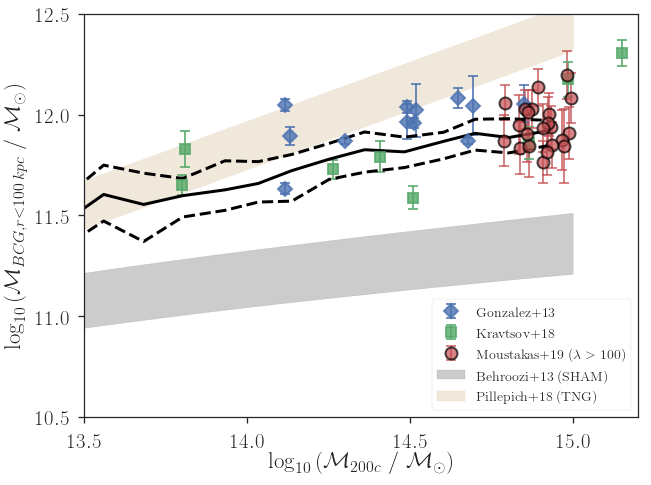

In [271]:
qa_smhm_obs(aperture='100kpc', png='mbcg-m200c-100kpc.png')

In [ ]:
qa_smhm_obs(aperture='rmax', png='mbcg-m200c-rmax.png')

(-0.5, 1)

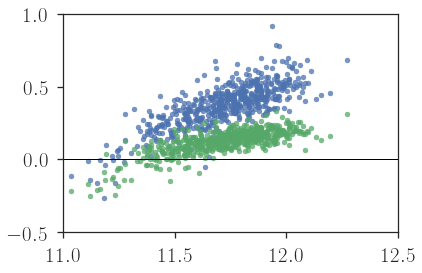

In [74]:
fig, ax = plt.subplots()
ax.scatter(profiles1dmstar['MSTAR100'], profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR10'], s=25, alpha=0.75)
ax.scatter(profiles1dmstar['MSTAR100'], profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR30'], s=25, alpha=0.75)
ax.axhline(y=0, color='k', lw=1, ls='-')
ax.set_xlim((11, 12.5))
ax.set_ylim(-0.5, 1)

(0, 1)

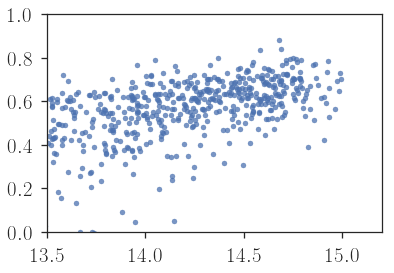

In [80]:
fig, ax = plt.subplots()
#ax.scatter(M200c, 10**(profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR10']), s=25, alpha=0.75)
ax.scatter(M200c, (10**profiles1dmstar['MSTAR100']-10**profiles1dmstar['MSTAR10'])/10**profiles1dmstar['MSTAR100'], s=25, alpha=0.75)
ax.axhline(y=0, color='k', lw=1, ls='-')
ax.set_xlim(13.5, 15.2)
ax.set_ylim(0, 1)

In [ ]:
pp = profiles1dmstar[1]
print(pp['MSTARRMAX'])
np.log10(np.cumsum(10**pp['MSTARRAD']))

In [ ]:
def mstar_label():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-2}\, \mathcal{M}_{\odot})$'
def mhalo_label():
    return r'$\log_{10}\, (\mathcal{M}_{\rm halo}\, /\, \mathcal{M}_{\odot})$'
def mstar_label2():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-1}\, \mathcal{M}_{\odot})$'
def mstar_label3():
    return r'$\log_{10}\, (\mathcal{M}_{*}\, /\, \mathcal{M}_{\odot})$'
def phi_label():
    return r'$\log_{10}\, (\Phi\ /\ h^{3}$ Mpc$^{-3}$ dex$^{-1})$'
def phi_label2():
    return r'$\log_{10}\, (\Phi\ /\ {\rm Mpc}^{-3}\ {\rm dex}^{-1})$'
def mstar_mhalo_label():
    return r'$log_{10}\, (\mathcal{M}_{*}\ /\ \mathcal{M}_{\rm halo})\ /\ (\Omega_b\ /\ \Omega_m)$'